### 1. Libraries

In [17]:
import os
import numpy as np
import IPython.display as ipd
import librosa
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

### 2. Define the Paths

In [18]:
DATASET_ROOT = r"C:\Users\DT\Documents\Homework\16000_pcm_speeches"
BENJAMIN_DATA = os.path.join(DATASET_ROOT, "Benjamin_Netanyau")
JENS_DATA = os.path.join(DATASET_ROOT, "Jens_Stoltenberg")
JULIA_DATA = os.path.join(DATASET_ROOT, "Julia_Gillard")
MARGARET_DATA = os.path.join(DATASET_ROOT, "Magaret_Tarcher")
NELSON_DATA = os.path.join(DATASET_ROOT, "Nelson_Mandela")

### 3. Cepstral Coefficients

In [19]:
def parse_dataset_mfcc(dataset_paths, n_mfcc=13, n_fft=1024, hop_length=512):
    """
    Parse audio dataset and extract MFCC features.

    Args:
        dataset_paths (list of str): list of folder paths, each containing audio files for a class
        n_mfcc (int): number of MFCC coefficients to extract per frame
        n_fft (int): FFT window size
        hop_length (int): hop length for FFT (stride between frames)

    Returns:
        X (list of np.ndarray): MFCC feature arrays of shape (n_mfcc, time_steps)
        y (list of int): corresponding class labels (integer)
    """
    X = []
    y = []

    for index, dataset in enumerate(dataset_paths):
        print(f"[+] Parsing {dataset} data...")

        for fname in os.listdir(dataset):
            wav, sr = librosa.load(os.path.join(dataset, fname), sr=None)

            # Extract MFCC features
            mfccs = librosa.feature.mfcc(
                y=wav,
                sr=sr,
                n_mfcc=n_mfcc,
                n_fft=n_fft,
                hop_length=hop_length
            )

            X.append(mfccs)
            y.append(index)
    return X, y



X, y = parse_dataset_mfcc([BENJAMIN_DATA, JENS_DATA, JULIA_DATA, MARGARET_DATA, NELSON_DATA])
print(f"Total parsed data {len(X)}")
print(f"Shape of one example: {X[0].shape} (n_mfcc, time_steps)")

[+] Parsing C:\Users\DT\Documents\Homework\16000_pcm_speeches\Benjamin_Netanyau data...
[+] Parsing C:\Users\DT\Documents\Homework\16000_pcm_speeches\Jens_Stoltenberg data...
[+] Parsing C:\Users\DT\Documents\Homework\16000_pcm_speeches\Julia_Gillard data...
[+] Parsing C:\Users\DT\Documents\Homework\16000_pcm_speeches\Magaret_Tarcher data...
[+] Parsing C:\Users\DT\Documents\Homework\16000_pcm_speeches\Nelson_Mandela data...
Total parsed data 7501
Shape of one example: (13, 32) (n_mfcc, time_steps)


### 4. Slip data (Training, Testing)

In [20]:
X_train, X_test, y_train, y_test = train_test_split( 
    X,
    y,
    test_size=0.05,
    random_state=42,
    stratify=y)

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

print("Length of training subset: ", len(X_train))
print("Lenght of testing subset: ", len(X_test))

Length of training subset:  7125
Lenght of testing subset:  376


### 5. Define Model (MLP)

In [21]:
X_train_flat = X_train.reshape(len(X_train), -1)
X_test_flat  = X_test.reshape(len(X_test), -1)

num_classes = len(set(y))

network = models.Sequential()
network.add(layers.Dense(150, activation='relu', input_shape=(X_train_flat.shape[1],)))
network.add(layers.Dense(68, activation='relu'))
network.add(layers.Dense(num_classes, activation='softmax'))

network.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

### 6. Fit Model

In [22]:
network.fit(
    X_train_flat,
    y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test_flat, y_test)
)

Epoch 1/20
223/223 [==============================] - 1s 2ms/step - loss: 2.9876 - accuracy: 0.8602 - val_loss: 0.8177 - val_accuracy: 0.9335
Epoch 2/20
223/223 [==============================] - 0s 2ms/step - loss: 0.6801 - accuracy: 0.9409 - val_loss: 0.3197 - val_accuracy: 0.9628
Epoch 3/20
223/223 [==============================] - 0s 1ms/step - loss: 0.3630 - accuracy: 0.9639 - val_loss: 0.8384 - val_accuracy: 0.9388
Epoch 4/20
223/223 [==============================] - 0s 2ms/step - loss: 0.1974 - accuracy: 0.9774 - val_loss: 0.4350 - val_accuracy: 0.9734
Epoch 5/20
223/223 [==============================] - 0s 1ms/step - loss: 0.1599 - accuracy: 0.9806 - val_loss: 0.7075 - val_accuracy: 0.9441
Epoch 6/20
223/223 [==============================] - 0s 1ms/step - loss: 0.1483 - accuracy: 0.9782 - val_loss: 0.3478 - val_accuracy: 0.9681
Epoch 7/20
223/223 [==============================] - 0s 1ms/step - loss: 0.1551 - accuracy: 0.9782 - val_loss: 1.1461 - val_accuracy: 0.8989
Epoch 

### 7. Metrics

In [23]:
X_test_flat = X_test.reshape(len(X_test), -1)

y_pred_proba = network.predict(X_test_flat)
y_pred = np.argmax(y_pred_proba, axis=1)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')
auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

print(f"Accuracy: {acc}")
print(f"F1-score: {f1}")
print(f"AUC: {auc}")

12/12 [==============================] - 0s 1ms/step
Accuracy: 0.9707446808510638
F1-score: 0.970812559591083
AUC: 0.9977985224689631


### 8. Confusion Matrix

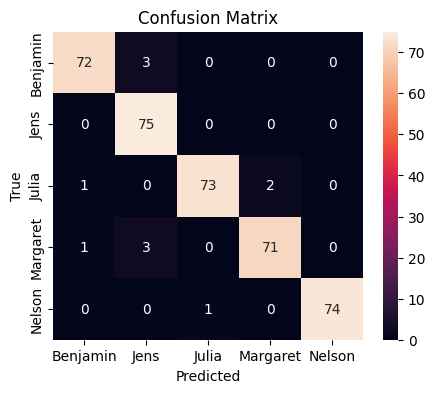

In [24]:
labels = ["Benjamin", "Jens", "Julia", "Margaret", "Nelson"]

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    xticklabels=labels,
    yticklabels=labels
)

plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()